Aim : Reproduce figure 2 and 3 from https://pubs.aip.org/aip/app/article/5/12/121301/123226/Generation-of-280-THz-spanning-near-ultraviolet


Z-cut LN: TE mode use No,and TM mode use No
T height : 600
r height: 100
width : 600-2100nm, steps 100
side-wall angle: 70 degree
sio2 bottom cladding

For z-CUT LNOI: no for the quasi-TE mode and ne for the quasi-TM mode, despite propagation direction

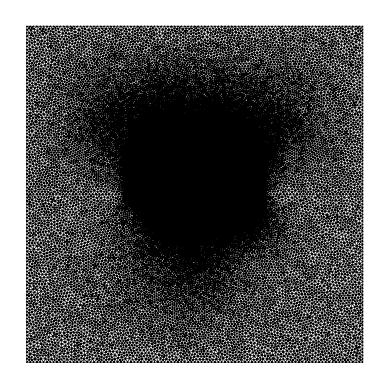

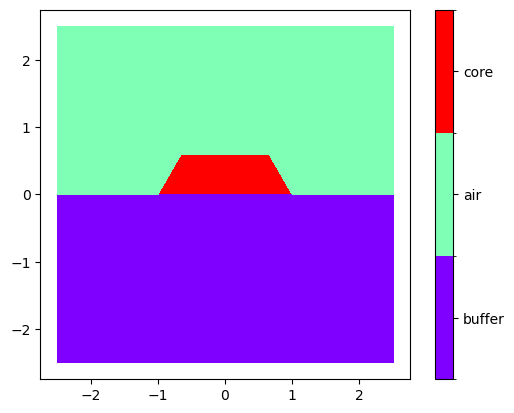

start


  0%|          | 0/1 [00:00<?, ?it/s]

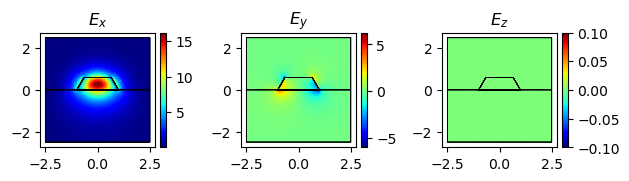

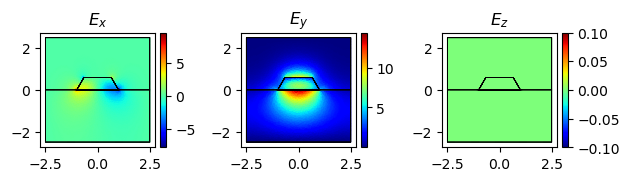

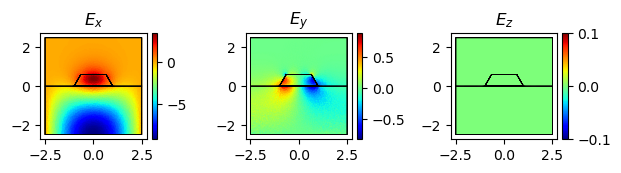

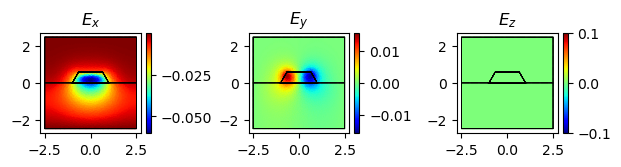

100%|██████████| 1/1 [02:01<00:00, 121.66s/it]

[4.28403694]
[1.41513749]
[1.92962785]
[1.57900047]


In [2]:

import math

from skfem import Basis, ElementTriP0
from tqdm import tqdm
from femwell.mesh import mesh_from_OrderedDict
from skfem.io import from_meshio
from femwell.visualization import plot_domains
import shapely
from femwell.maxwell.waveguide import compute_modes
from refractive_index import n_SiO2, n_Air, n_LNOI
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon

wavelength_range = [500, 3100]
wavelegnth_step = 70
ray = "o"

n_core = lambda w: n_LNOI(w, ray=ray)
n_buffer = n_SiO2
n_air = n_Air

# waveguide parameters
#bottom_width = 2 # um
top_width = 2
box_height = 5
triangle_height = 0.6
triangle_width = triangle_height/ math.tan(60 * math.pi /180)

# Construct waveguide geometry
"""
core = Polygon([(bottom_width/2,0 ),(-bottom_width/2, 0),(-bottom_width/2 + triangle_width, triangle_height) , (bottom_width/2 - triangle_width, triangle_height)])
buffer = shapely.geometry.box(-box_height/2,-box_height/2,box_height/2,0)
air = shapely.geometry.box(-box_height/2,0,box_height/2,box_height/2)
"""
core = Polygon([(top_width/2 + triangle_width,0 ),(-top_width/2-triangle_width, 0),(-top_width/2, triangle_height) , (top_width/2, triangle_height)])
buffer = shapely.geometry.box(-box_height/2,-box_height/2,box_height/2,0)
air = shapely.geometry.box(-box_height/2,0,box_height/2,box_height/2)

polygon = OrderedDict(
    core = core,
    buffer = buffer,
    air= air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.02, "distance": 0.1},
                   buffer={"resolution": 0.06, "distance": 0.5},
                   air={"resolution": 0.08, "distance": 0.5})

n_dict = {"core": n_core, "buffer": n_buffer, "air": n_air}

mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
mesh.draw().show()
plot_domains(mesh)
plt.show()

#----------------------FEM solver-------------------------------
print("start")
# Calculate dispersion and gamma
mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
wavelength_list = np.array([3000])
neff_list_te = []
aeff_list_te = []
neff_list_tm = []
aeff_list_tm = []

for wavelength in tqdm(wavelength_list):
    wavelength = wavelength * 1e-3
    for subdomain, n in n_dict.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n(wavelength) ** 2
    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)
    
    ## te mode
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.n_eff))
    mode = modes_sorted[0]
    neff_list_te.append(np.real(mode.n_eff))
    aeff_list_te.append(mode.calculate_effective_area())
    mode.show(mode.E.real, direction = "x")
    modes_sorted[1].show(modes_sorted[1].E.real, direction = "x")
    modes_sorted[2].show(modes_sorted[2].E.real, direction = "x")

    ## tm mode
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.tm_fraction))
    if modes_sorted[0].tm_fraction < 0.7:
        print(f"at {wavelength}um, mode has highest tm_fraction of f{modes_sorted[0].tm_fraction}")
    mode = modes_sorted[0]
    neff_list_tm.append(np.real(mode.n_eff))
    aeff_list_tm.append(mode.calculate_effective_area())
    mode.show(mode.H.real, direction = "x")

neff_list_te = np.array(neff_list_te)
aeff_list_te = np.array(aeff_list_te)

neff_list_tm = np.array(neff_list_tm)
aeff_list_tm = np.array(aeff_list_tm)
wls = np.array(wavelength_list)
print(aeff_list_tm)
print(neff_list_tm)
print(aeff_list_te)
print(neff_list_te)


Plot the effective refractive index and calculate the GVD and dispersion operator

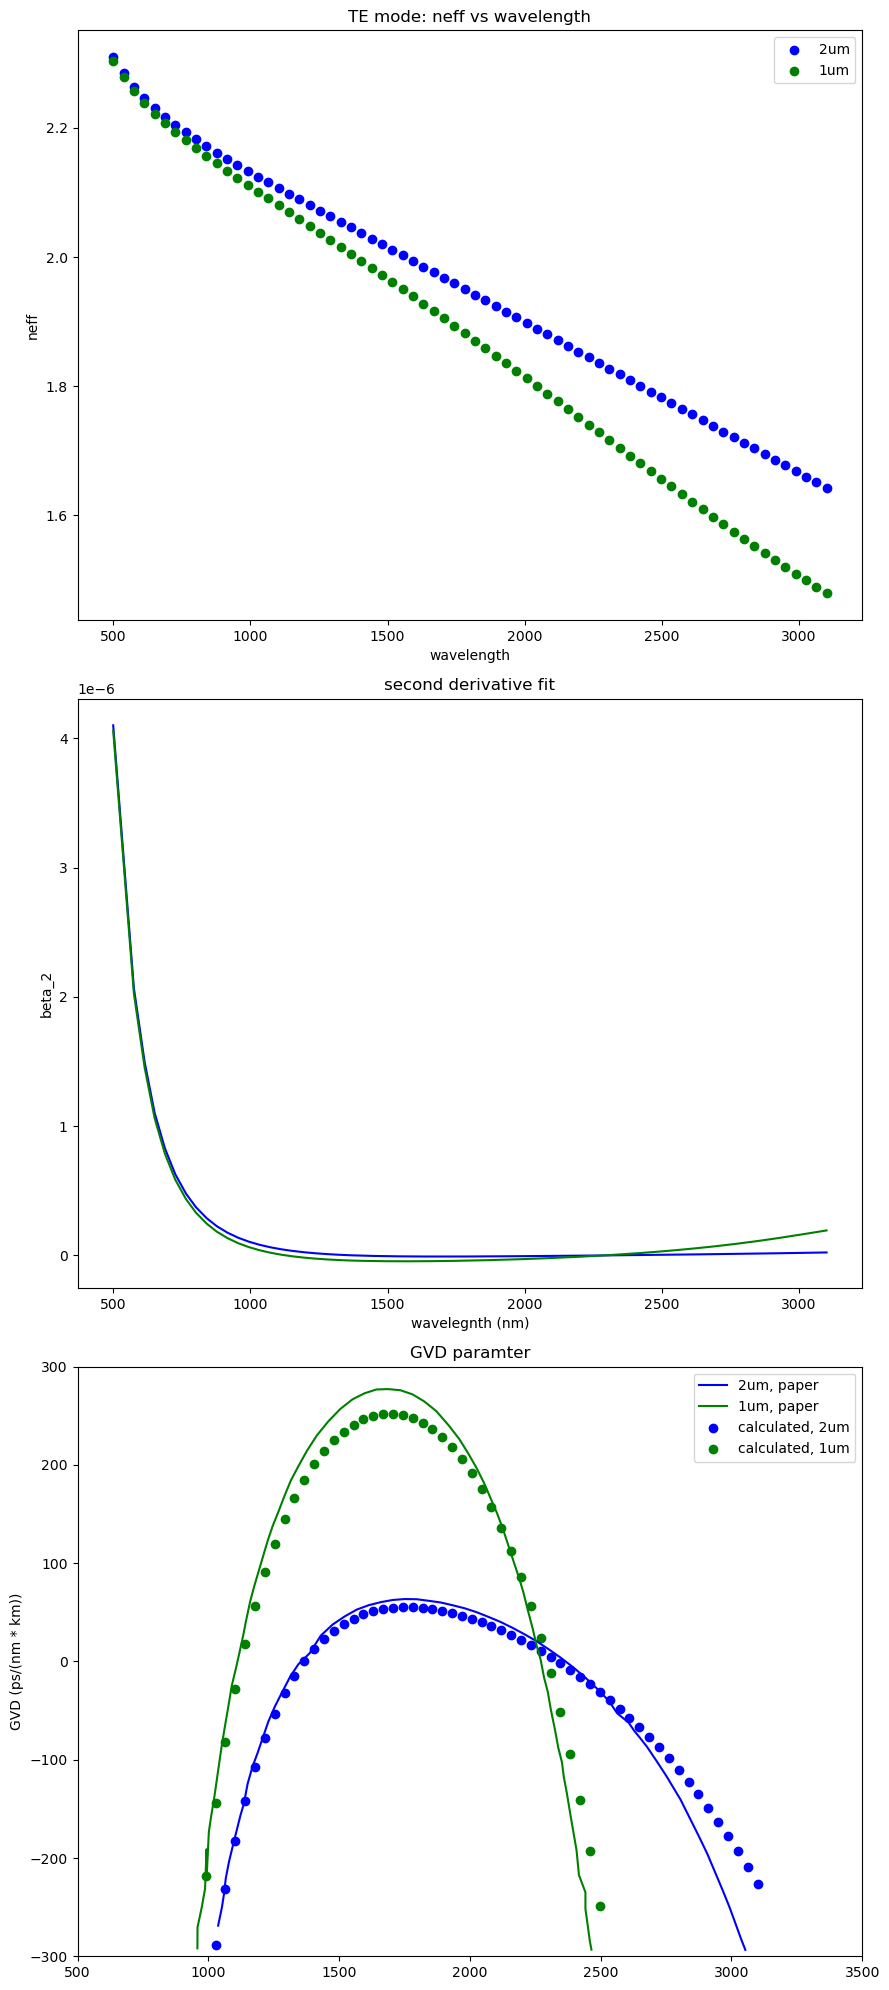

In [16]:
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from refractive_index import n_Si3N4
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c
import pandas as pd

top_width = 2
box_height = 5
triangle_height = 0.6

data_2um = np.load(f"data_h_{0.6}_w_{2}_o.npz")
data_1um = np.load(f"data_h_{0.6}_w_{1}_o.npz")
neff_list_2um = np.array(np.real(data_2um['neff_list_te']))
neff_list_1um = np.array(np.real(data_1um['neff_list_te']))
wls_2um = data_2um["wls"]
wls_1um = data_1um["wls"]

fig, axs = plt.subplots(3, 1, figsize=(9,20))

#-----------fit neff spline----------------------------------
y_spl_2um = UnivariateSpline(wls_2um,neff_list_2um,s=0,k=3)
y_spl_1um = UnivariateSpline(wls_1um,neff_list_1um,s=0,k=3)
w_range = np.linspace(wls_2um[0],wls_2um[-1],1000)

#-----------neff plot-----------------
axs[0].set_xlabel("wavelength")
axs[0].set_ylabel("neff")
axs[0].set_title("TE mode: neff vs wavelength")
axs[0].scatter(wls_2um,neff_list_2um, color="blue", label = "2um")
axs[0].scatter(wls_1um,neff_list_1um, color="green", label = "1um")
axs[0].legend()

#-----------second derivative plot-----------------
y_spl_2d_2um = y_spl_2um.derivative(n=2)
y_spl_2d_1um = y_spl_1um.derivative(n=2)
axs[1].set_xlabel("wavelegnth (nm)")
axs[1].set_ylabel("beta_2")
axs[1].set_title("second derivative fit")
axs[1].plot(w_range,y_spl_2d_2um(w_range) , color="blue")
axs[1].plot(w_range,y_spl_2d_1um(w_range) , color="green")


#-----------plot reference data __________________
ref_2um = pd.read_csv("../reference_data/2um.csv", dtype=np.float64)
ref_2um_x, ref_2um_y = np.split(ref_2um.values, 2, axis=1)
axs[2].plot(ref_2um_x, ref_2um_y, c="blue", label = "2um, paper")

ref_1um = pd.read_csv("../reference_data/1um.csv", dtype=np.float64)
ref_1um_x, ref_1um_y = np.split(ref_1um.values, 2, axis=1)
axs[2].plot(ref_1um_x, ref_1um_y, c="green", label = "1um, paper")
#-----------GVD plot---------------------------
GVD_2um=(-wls_2um/(2.99792e-7 ) * y_spl_2d_2um(wls_2um))
GVD_1um=(-wls_1um/(2.99792e-7 ) * y_spl_2d_1um(wls_2um))

axs[2].scatter(wls_2um, GVD_2um, label = "calculated, 2um", c="blue")
axs[2].scatter(wls_1um, GVD_1um, label = "calculated, 1um", c="green")

axs[2].set_ylabel("GVD (ps/(nm * km))")
axs[2].set_ylim(-300,300)
axs[2].set_xlim(500,3500)
axs[2].set_title("GVD paramter")
axs[2].legend()

plt.tight_layout()
plt.show()

0.4419557322288605
   0.5% - 5.025e-05 m - 0.0 seconds
   1.0% - 1.005e-04 m - 0.0 seconds
   1.5% - 1.508e-04 m - 0.0 seconds
   2.0% - 2.010e-04 m - 0.0 seconds
   2.5% - 2.513e-04 m - 0.0 seconds
   3.0% - 3.015e-04 m - 0.0 seconds
   3.5% - 3.518e-04 m - 0.1 seconds
   4.0% - 4.020e-04 m - 0.1 seconds
   4.5% - 4.523e-04 m - 0.1 seconds
   5.0% - 5.025e-04 m - 0.1 seconds
   5.5% - 5.528e-04 m - 0.1 seconds
   6.0% - 6.030e-04 m - 0.1 seconds
   6.5% - 6.533e-04 m - 0.1 seconds
   7.0% - 7.035e-04 m - 0.1 seconds
   7.5% - 7.538e-04 m - 0.1 seconds
   8.0% - 8.040e-04 m - 0.1 seconds
   8.5% - 8.543e-04 m - 0.1 seconds
   9.0% - 9.045e-04 m - 0.1 seconds
   9.5% - 9.548e-04 m - 0.1 seconds
  10.1% - 1.005e-03 m - 0.1 seconds
  10.6% - 1.055e-03 m - 0.1 seconds
  11.1% - 1.106e-03 m - 0.1 seconds
  11.6% - 1.156e-03 m - 0.1 seconds
  12.1% - 1.206e-03 m - 0.2 seconds
  12.6% - 1.256e-03 m - 0.2 seconds
  13.1% - 1.307e-03 m - 0.2 seconds
  13.6% - 1.357e-03 m - 0.2 seconds
  14.1% -

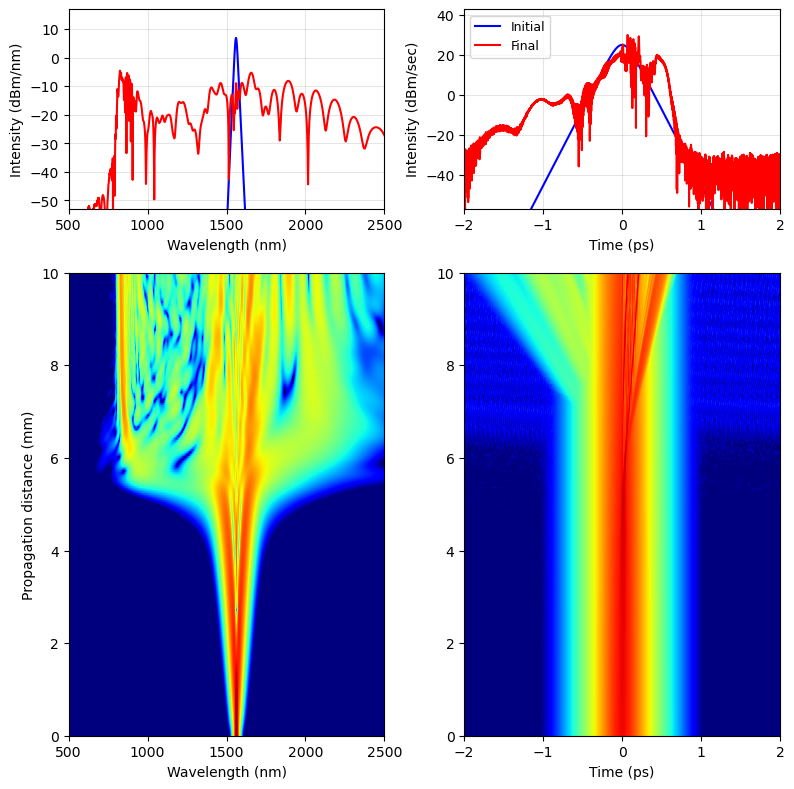

In [11]:
import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c

# pulse parameters
FWHM = 200 * 1e-3  # pulse duration (ps)
pulseWL = 1560  # pulse central wavelength (nm)
length = 10 *1e-3

power = 4000  # W
GDD = False  # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion
rep_rate = 80 * 1e6 # rep rate in hz
# simulation parameters
Window = 4  # simulation window (ps)
Steps = 200  # simulation steps
Points = 2 ** 14  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4 # absolute error
Raman = False  # Enable Raman effect?
Steep = True  # Enable self steepening?

ray = "o"
top_width = 1.75  # um
box_height = 5
triangle_height = 0.6
# ----------- Build Waveguide -----------
n2 = 1e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.16  # loss (dB/cm)

data = np.load(f"data_h_{triangle_height}_w_{top_width}_{ray}.npz")
wls = data['wls']
neff_list = data['neff_list_te']
aeff_list = data['aeff_list_te']


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


# Calculate Gamma
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(pump_wl) * 1e-12)
    return gamma
print(gamma_function(pulseWL))

# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, power_is_avg=False, power=power, GDD=GDD, TOD=TOD, FOD=FOD,
             npts=Points)
p.add_noise()
# create the waveguide
f = lf.Fiber(length, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma_function(pulseWL), loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)
###
fig, axes = results.plot(wavelength=True, show=False, tlim=(-2, 2), flim=(500, 2500), units="dBm/nm", rep_rate = rep_rate )

plt.set_cmap('jet')
plt.show()


Propagate laser to the waveguide using pynlo

C:\Users\a1890865\AppData\Local\Temp\ipykernel_23720\4094088314.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


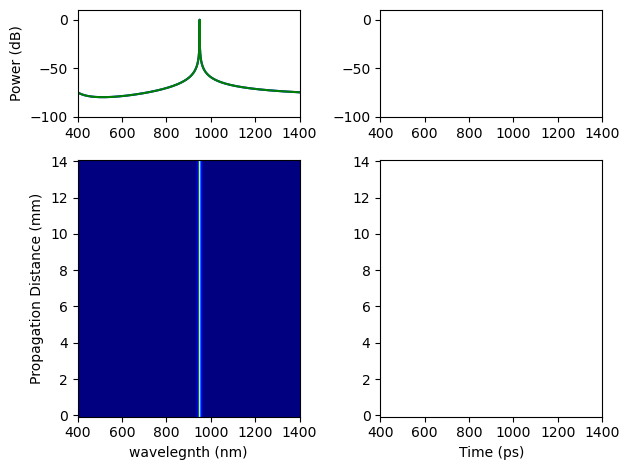

In [13]:
import numpy as np
import pynlo
from scipy.constants import pi, c
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import pi, c
from matplotlib import pyplot as plt

import pynlo
from pynlo import utility as ut
def plot(pulse, z, a_t, a_v, xlim, ylim=None, tlim=None ):
    w_grid = c/(pulse.v_grid)*1e9
    fig = plt.figure("Simulation Results", clear=True)
    ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
    ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
    ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
    ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)

    p_v_dB = 10*np.log10(np.abs(a_v)**2)
    p_v_dB -= p_v_dB.max()

    ax0.plot(w_grid, p_v_dB[0], color="b")
    ax0.plot(w_grid, p_v_dB[-1], color="g")
    ax2.pcolormesh(w_grid, 1e3*z, p_v_dB, vmin=np.max(p_v_dB) - 50, vmax=np.max(p_v_dB), shading="auto", cmap="jet")
    ax0.set_ylim(np.max(p_v_dB[0]) - 100,np.max(p_v_dB[0]) + 10)
    ax1.set_ylim(np.max(p_v_dB[-1]) - 100,np.max(p_v_dB[-1]) + 10)
    ax0.set_xlim(left = xlim[0], right = xlim[1])
    ax2.set_xlabel('wavelegnth (nm)')

    p_t_dB = 10*np.log10(np.abs(a_t)**2)
    p_t_dB -= p_t_dB.max()
    ax1.plot(1e12*pulse.t_grid, p_t_dB[0], color="b")
    ax1.plot(1e12*pulse.t_grid, p_t_dB[-1], color="g")
    ax3.pcolormesh(1e12*pulse.t_grid, 1e3*z, p_t_dB, vmin=np.max(p_v_dB) - 80, vmax=np.max(p_v_dB), shading="auto", cmap="jet")
    ax1.set_xlim(left = xlim[0], right = xlim[1])
    ax3.set_xlabel('Time (ps)')
    
    if ylim:
        ax0.set_ylim(bottom=ylim[0], top=ylim[1])
        ax1.set_ylim(bottom=ylim[0], top=ylim[1])
    
    if tlim:
        ax2.set_xlim(left = tlim[0], right = tlim[1])
        ax3.set_xlim(left = tlim[0], right = tlim[1])

    ax0.set_ylabel('Power (dB)')
    ax2.set_ylabel('Propagation Distance (mm)')
    fig.tight_layout()
    fig.show()
    
def dB(num):
    with np.errstate(divide='ignore'):
        return 10 * np.log10(np.abs(num)**2)
    
n_points = 2**13
center_wl = 950 *1e-9
start_wl = 400 *1e-9
end_wl = 1400 *1e-9
e_p = 13e-12       # energy per pulse in joules
t_fwhm = 220e-15  * np.sqrt(2)   # for sech, fwhm = 1.76 * pulse duration 

f_min = c/(end_wl)   # c / l
f_max = c/(start_wl)    # c / l
f0 = c/center_wl       # c / 835 nm


pulse = pynlo.light.Pulse.Sech(n_points, f_min, f_max, f0,e_p, t_fwhm, alias=2) # alias = number of harmonic support by the real-valued time domain grid

'''
dbm = dB(pulse.a_v)
fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax0.set_xlabel('frequency (THz)')
ax0.plot(1e-12*pulse.v_grid, dbm, color="b")
plt.show()
'''
data = np.load("data_h_0.25_w_0.7_no.npz")
wls = data['wls'][:66] * 1e-9
aeff_list = data['aeff_list_tm']
neff_list = data['neff_list_tm']

aeff_interp = scipy.interpolate.interp1d(wls,aeff_list)
neff_interp = scipy.interpolate.interp1d(wls,neff_list)

length = 14e-3 # 14 mm
a_eff = aeff_interp(center_wl) * 1e-12

#---- Phase Coefficient
w_grid = c/pulse.v_grid 
n_eff = neff_interp(w_grid)

beta = n_eff * 2*pi*pulse.v_grid/c

#---- 2nd-order nonlinearity
d_eff = 33e-12 # 30 pm / V
chi2_eff = 2 * d_eff
g2 = ut.chi2.g2_shg(f0, pulse.v_grid, n_eff, a_eff, chi2_eff)

# Poling
p0 = 30e-6 # 30 um poling period
z_invs, domains, poled = ut.chi2.domain_inversions(length, 2*pi/p0)

'''
# 3rd-Order Nonlinearity
gamma = #1/(W*m)
g3 = ut.chi3.gamma_to_g3(pulse.v_grid, gamma)

# Raman effect
r_weights = [0.245*(1-0.21), 12.2e-15, 32e-15] # resonant contribution
b_weights = [0.245*0.21, 96e-15] # boson contribution
rv_grid, raman = ut.chi3.raman(pulse.n, pulse.dt, r_weights, b_weights)

mode = pynlo.medium.Mode(pulse.v_grid, beta, g3=g3, rv_grid=rv_grid, r3=raman)
'''
mode = pynlo.medium.Mode(pulse.v_grid, beta, g2=g2, g2_inv=z_invs)

#----build model
model = pynlo.model.UPE(pulse, mode)

#---- Estimate step size
local_error = 1e-6
dz = model.estimate_step_size(local_error=local_error)
    
pulse_out, z, a_t, a_v = model.simulate(length, dz=dz, local_error=local_error, n_records=100, plot=None)
plot(pulse_out,z,a_t,a_v,xlim=(400,1400))